<a href="https://colab.research.google.com/github/Manvi0509/Manvi0509.github.io/blob/main/GRU_QR_85quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [56]:
# Load your AQI data
data = pd.read_excel(r"/content/DELHI_AQI.xlsx")
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data.set_index('Timestamp', inplace=True)

In [57]:
# Remove leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Define the columns for which you want to create lag features
columns = ['Max temp', 'Min temp', 'precip', 'windspeed', 'winddir',
           'PM2.5', 'PM10', 'NO2', 'SO2', 'Max 8-h CO', 'Max 8-h Ozone', 'AQI']


In [58]:
# Check which columns exist in the dataset
existing_columns = [col for col in columns if col in data.columns]

In [59]:
# Generate 1 lag for each available column (including original)
lags = 1
for col in existing_columns:
    # Create lagged feature
    data[f'{col}lag{lags}'] = data[col].shift(lags)
# Drop rows with NaN values (from lagged features)
data = data.dropna()

In [60]:
data

,AQI,Max temp,Min temp,precip,windspeed,winddir,PM2.5,PM10,NO2,SO2,...,preciplag1,windspeedlag1,winddirlag1,PM2.5lag1,PM10lag1,NO2lag1,SO2lag1,Max 8-h COlag1,Max 8-h Ozonelag1,AQIlag1
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-02,418,17.4,8.0,0.0,9.4,287.8,280.470588,439.810833,53.138824,11.885000,...,0.0,9.4,296.6,304.632353,440.251667,60.750588,17.066250,1.987692,34.130714,406.0
2018-01-03,382,17.2,8.0,0.0,11.2,270.8,219.991765,344.039167,53.151765,10.188750,...,0.0,9.4,287.8,280.470588,439.810833,53.138824,11.885000,1.708571,30.698571,418.0
2018-01-04,366,20.2,5.0,0.0,13.0,120.0,245.572941,395.775833,60.116471,14.302500,...,0.0,11.2,270.8,219.991765,344.039167,53.151765,10.188750,1.597143,31.054286,382.0
2018-01-05,390,19.0,7.4,0.0,11.2,112.3,241.658235,365.410000,55.786471,13.583750,...,0.0,13.0,120.0,245.572941,395.775833,60.116471,14.302500,1.477857,35.047143,366.0
2018-01-06,405,19.0,5.0,0.0,11.2,277.5,255.643529,390.452500,58.799375,17.837500,...,0.0,11.2,112.3,241.658235,365.410000,55.786471,13.583750,1.843846,28.534286,390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,380,19.6,10.3,0.0,9.4,255.4,263.062704,385.153366,43.086853,8.867617,...,0.0,9.4,273.0,232.961983,358.345341,47.209648,8.970924,2.456401,32.644029,377.0
2023-12-28,358,19.5,9.3,0.0,9.4,258.5,189.884393,295.297592,35.559144,9.113285,...,0.0,9.4,255.4,263.062704,385.153366,43.086853,8.867617,2.313868,20.082292,380.0
2023-12-29,382,18.6,12.0,0.0,9.4,208.2,254.382753,406.617265,42.960487,9.634018,...,0.0,9.4,258.5,189.884393,295.297592,35.559144,9.113285,1.875346,21.922238,358.0


In [61]:
# Define predictors (both original and lagged features)
predictors = [f'{col}lag{lags}' for col in existing_columns]

In [62]:
# Define the training and testing data (80-20 split)
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

In [63]:
train_size


1752

In [64]:
test_data

,AQI,Max temp,Min temp,precip,windspeed,winddir,PM2.5,PM10,NO2,SO2,...,preciplag1,windspeedlag1,winddirlag1,PM2.5lag1,PM10lag1,NO2lag1,SO2lag1,Max 8-h COlag1,Max 8-h Ozonelag1,AQIlag1
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-10-20,229,33.3,19.4,0.0,2.7,118.4,110.621351,272.467222,63.034054,10.303125,...,0.0,3.2,202.4,101.475135,267.813784,60.100000,9.860938,2.651667,60.179474,229.0
2022-10-21,282,32.4,20.0,0.0,2.9,273.0,116.680541,285.822703,58.447105,10.045000,...,0.0,2.7,118.4,110.621351,272.467222,63.034054,10.303125,2.278158,61.690263,229.0
2022-10-22,271,31.0,20.0,0.0,5.2,279.2,121.996216,268.609730,48.592105,9.488750,...,0.0,2.9,273.0,116.680541,285.822703,58.447105,10.045000,2.537368,61.134474,282.0
2022-10-23,237,31.0,17.4,0.0,2.4,276.0,128.514474,258.907568,51.562895,12.581250,...,0.0,5.2,279.2,121.996216,268.609730,48.592105,9.488750,1.657838,60.361316,271.0
2022-10-24,333,31.0,17.8,0.0,4.0,278.9,173.721053,279.755135,44.383158,17.091875,...,0.0,2.4,276.0,128.514474,258.907568,51.562895,12.581250,1.924595,70.040811,237.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,380,19.6,10.3,0.0,9.4,255.4,263.062704,385.153366,43.086853,8.867617,...,0.0,9.4,273.0,232.961983,358.345341,47.209648,8.970924,2.456401,32.644029,377.0
2023-12-28,358,19.5,9.3,0.0,9.4,258.5,189.884393,295.297592,35.559144,9.113285,...,0.0,9.4,255.4,263.062704,385.153366,43.086853,8.867617,2.313868,20.082292,380.0
2023-12-29,382,18.6,12.0,0.0,9.4,208.2,254.382753,406.617265,42.960487,9.634018,...,0.0,9.4,258.5,189.884393,295.297592,35.559144,9.113285,1.875346,21.922238,358.0


In [65]:
X_train = train_data[predictors]
y_train = train_data['AQI']
X_test = test_data[predictors]
y_test = test_data['AQI']


In [66]:
print(X_train,y_test)

            Max templag1  Min templag1  preciplag1  windspeedlag1  \
Timestamp                                                           
2018-01-02          20.0           6.0         0.0            9.4   
2018-01-03          17.4           8.0         0.0            9.4   
2018-01-04          17.2           8.0         0.0           11.2   
2018-01-05          20.2           5.0         0.0           13.0   
2018-01-06          19.0           7.4         0.0           11.2   
...                  ...           ...         ...            ...   
2022-10-15          30.8          21.0         0.0            5.7   
2022-10-16          32.0          21.0         0.0            3.5   
2022-10-17          32.0          19.6         0.0            3.3   
2022-10-18          31.6          19.4         0.0            3.9   
2022-10-19          33.0          19.6         0.0            3.2   

            winddirlag1   PM2.5lag1    PM10lag1    NO2lag1    SO2lag1  \
Timestamp                    

In [67]:
# Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [68]:
# Reshape for GRU (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [69]:
print(len(X_train))

1752


In [70]:
# Define the custom Quantile Loss function
def quantile_loss(y_true, y_pred, quantile=0.85):
    error = y_true - y_pred
    loss = K.mean(K.maximum(quantile * error, (quantile - 1) * error), axis=-1)
    return loss

In [71]:
# Define GRU model
model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)  # Output one value per input sample
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [72]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_5 (GRU)                          │ (None, 64)                  │          14,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,089 (66.75 KB)

 Trainable params: 17,089 (66.75 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
# Compile the model with the Quantile Loss
model.compile(optimizer=Adam(learning_rate=0.01), loss=lambda y_true, y_pred: quantile_loss(y_true, y_pred, quantile=0.85))

In [74]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 143.8214 - val_loss: 24.0398
Epoch 2/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25.2549 - val_loss: 22.5553
Epoch 3/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.7291 - val_loss: 9.7622
Epoch 4/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5499 - val_loss: 8.2625
Epoch 5/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8130 - val_loss: 8.1130
Epoch 6/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6399 - val_loss: 8.1073
Epoch 7/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4913 - val_loss: 8.2588
Epoch 8/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2610 - val_loss: 8.6334
Epoch 9/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5007 - val_loss: 7.9677
Epoch 10/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8024 - val_loss: 8.1798
Epoch 11/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4334 - val_loss: 8.0934
Epoch 12/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0670 -

In [75]:
# Predict on test data
predictions = model.predict(X_test).flatten()

# Compare actual vs predicted values
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': predictions.flatten()})
print(comparison.head(50))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
            Actual   Predicted
Timestamp                     
2022-10-20     229  308.370361
2022-10-21     282  303.301392
2022-10-22     271  325.177277
2022-10-23     237  304.457153
2022-10-24     333  302.021942
2022-10-25     303  314.979156
2022-10-26     282  310.569336
2022-10-27     350  326.781769
2022-10-28     355  373.216675
2022-10-29     403  390.095154
2022-10-30     348  408.771210
2022-10-31     379  391.511292
2022-11-01     419  426.427612
2022-11-02     384  416.308990
2022-11-03     459  406.790558
2022-11-04     434  463.608521
2022-11-05     369  441.676117
2022-11-06     333  360.241913
2022-11-07     332  348.308502
2022-11-08     356  363.685699
2022-11-09     264  397.370331
2022-11-10     281  303.852997
2022-11-11     304  337.428680
2022-11-12     291  358.096252
2022-11-13     277  336.435577
2022-11-14     246  334.268311
2022-11-15     165  318.471191
2022-11-16     233  274.042999
2022-11-17     198  272.548340

In [76]:
# Calculate error metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)


In [77]:
# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r2}')

Mean Absolute Error (MAE): 40.52867126464844
Mean Squared Error (MSE): 2742.80029296875
R-squared: 0.7660186886787415


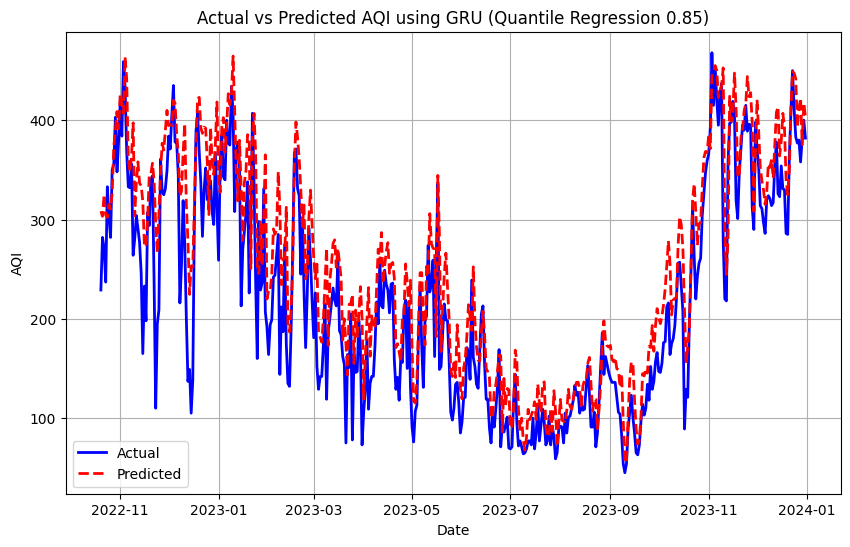

In [78]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', linestyle='-', linewidth=2)
plt.plot(y_test.index, predictions, label='Predicted', color='red', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Actual vs Predicted AQI using GRU (Quantile Regression 0.85)')
plt.legend()
plt.grid(True)
plt.show()